In [28]:
import pdb
import re
import ocr_utils  ## install from github.com/redshiftzero/handledocs/

# OCR documents

In [3]:
foia_response = '1505Deposits.pdf'
ocr_utils.split_pdf(foia_response)

num_page_start = 3
num_page_end = 23
all_text = []

# OCR every page in the document from num_page_start to num_page_end 
# and store the result in all_text
for page in range(num_page_start, num_page_end + 1):
    indiv_filename = "{}.{}.pdf".format(ocr_utils.get_stem(foia_response), page)
    
    tmp_filename = ocr_utils.rotate_pdf(indiv_filename)
    tmp_image = ocr_utils.convert_to_png(tmp_filename)
    all_text.append(ocr_utils.ocr_image(tmp_image))

# Fix any errors

By going through page by page and checking each row. 

In [4]:
# Pull out rows with dollar signs in them
cash_regex = re.compile('.*\$\d*.*')
dates_regex = re.compile('.*/.*/.*')

In [5]:
def get_monies(text):
    relevant_rows = []
    each_page = text.split('\n')
    for row in each_page:
        relevant_rows.append(cash_regex.findall(row))
    matched = [x for x in relevant_rows if x]
    return matched

def get_dates(text):
    relevant_rows = []
    each_page = text.split('\n')
    for row in each_page:
        relevant_rows.append(dates_regex.findall(row))
    matched = [x for x in relevant_rows if x]
    return matched

In [6]:
get_monies('$200\npotato')

[['$200']]

In [7]:
get_dates('01/01/01\n potato\n 05/02/0333')

[['01/01/01'], [' 05/02/0333']]

In [49]:
final_rows = []
num_pages = num_page_end - num_page_start + 1

# Fix any OCR errors
for page in range(num_pages):
    page_rows = get_monies(all_text[page])
    if page == 0:
        page_rows[0] = ['01/02/2009 $1424.54']
    elif page == 2:
        page_rows[4] = ['06/22/2009 $541,602.27']
        page_rows[25] = ['08/05/2009 $62.55']
        page_rows[28] = ['08/13/2009 $92.65']
    elif page == 6:
        page_rows.append(['03/03/2010 $19,757.42'])
        page_rows[10] = ['03/25/2010 $1,800.00']
        page_rows[11] = ['04/05/2010 $701,162.24']
        page_rows[15] = ['04/09/2010 $11,300.00']
    elif page == 8:
        page_rows[2] = ['04/12/2011 $60,000.00']
    elif page == 9:
        page_rows[13] = ['02/02/2012 $1,095.64']
    elif page == 11:
        # row formatting messed up, fixing:
        page_dates = get_dates(all_text[page])
        page_all = list(zip(page_dates, page_rows))
        page_rows = ['{} {}'.format(x, y) for ([x],[y]) in page_all]
        page_rows[22] = '02/06/2013 $1,200.00'
        page_rows.append('09/24/2012 $1,102.09')
    elif page == 17:
        page_rows = ['02/19/2016 $1,252.96']
    elif page == 18:
        page_rows[2] = ['03/31/2010 $696.10']
    elif page == 19:
        page_rows[13] = ['08/31/2013 $1,459.31']
    
    final_rows += page_rows

In [50]:
dates = []
monies = []
for x in range(len(blah)):
    tempdata = str(final_rows[x]).split('$')
    dates.append(tempdata[0].replace("(", "").replace(")", "").lstrip("['").replace(" ", "").replace(".", ""))
    monies.append(tempdata[1].replace("(", "").replace(")", "").rstrip("']").replace(" ", "").replace(",", ""))

# Descriptive Statistics

In [51]:
import pandas as pd

In [52]:
df = pd.DataFrame({'dates': dates, 'amount': monies})

In [56]:
df['dates'] = pd.to_datetime(df['dates'], format="%m/%d/%Y")

In [63]:
df['amount'] = df['amount'].map(lambda x: float(x))

Total amount of money seized from people by CPD since 2009: 

In [64]:
import numpy as np
np.sum(df['amount'])

47785712.539999992

47 MILLION!!!!!!!!!!!! 

In [66]:
np.max(df['amount'])

2084051.8999999999

In [67]:
np.mean(df['amount'])

80177.370033557032

# Seizures as a function of time

In [69]:
df['year'] = df['dates'].map(lambda x: x.year)

In [82]:
df['amount'].groupby(df['year']).sum()

year
2009    9316199.57
2010    5991453.40
2011    6988732.19
2012    5516524.53
2013    5180522.15
2014    8998228.97
2015    4662242.80
2016    1131808.93
Name: amount, dtype: float64

In [122]:
dfannotate = df['amount'].groupby(df['year']).sum()

In [127]:
dfannotate.index

Int64Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype='int64', name='year')

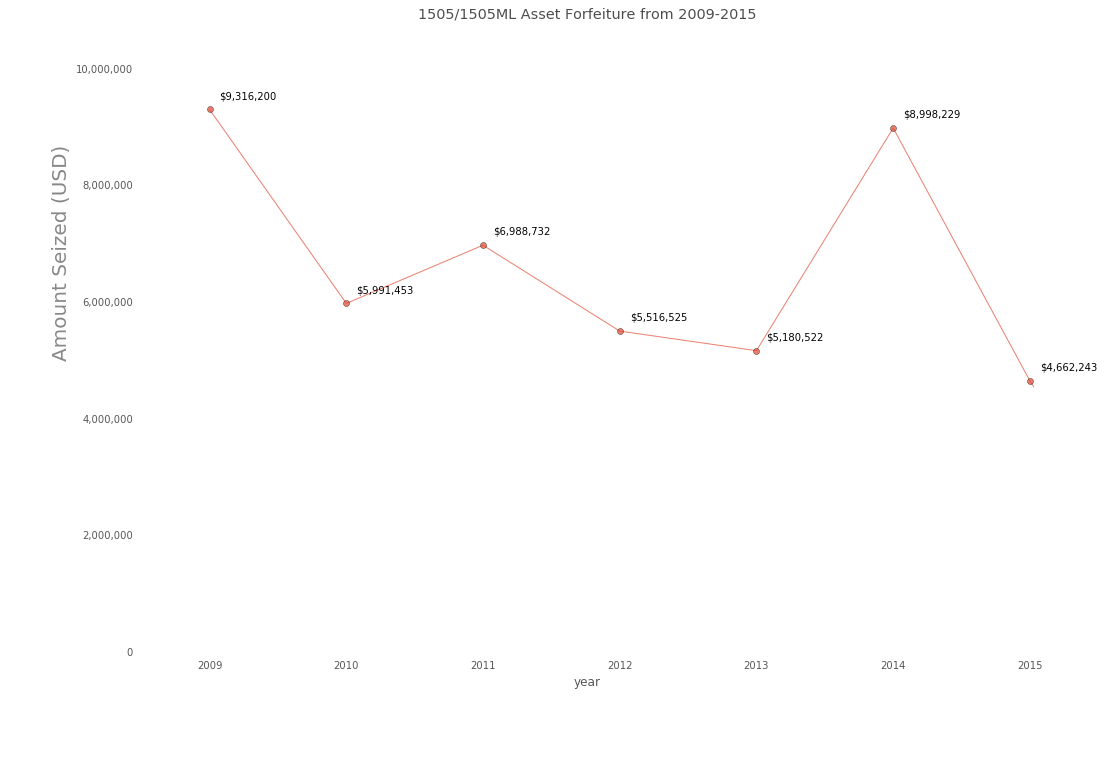

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
mytitle = '1505/1505ML Asset Forfeiture from 2009-2015'
a = 0.7

# Remove grid lines
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)
 
# Title
ax.set_title(ax.get_title(), fontsize=36, alpha=a, ha='left')
plt.subplots_adjust(top=0.8)
ax.title.set_position((0.5,1.08))
 
# Axis labels
ax.xaxis.set_label_position('bottom')
ylab = 'Amount Seized (USD)'
ax.set_ylabel(ylab, fontsize=20, alpha=a, ha='left')

# People don't understand scientific notation
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)

# Use commas instead
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
    
df['amount'].groupby(df['year']).sum().plot(ax=ax, alpha=a, legend=False,
                      xlim=(2008.5,2015.03), ylim=(0, 10000000), title=mytitle, marker='o')
# Annotate each point
for each_year in list(dfannotate.index):
    ax.annotate("${0:,.0f}".format(dfannotate[each_year]),
             (each_year, dfannotate[each_year]),
             xytext=(10, 10), 
             textcoords='offset points')